# What's the chance that an effect is real? Using simulation to get statistical insights

Let's say you observe some effect in the market and quantify it with some simple data analysis. 

A good question to ask is, "What are the chances I'd see this effect solely due to chance?"

And using some simple coding tools, we can answer this question without doing any formal statistics. 

Before we get into it, it's worth noting that while answering this can give you some insight into the effect, it relies on you not torturing your data too much. 

Imagine you curve fit the hell out of something. By design, you've zeroed in on something that is genuinely unusual, but only due to chance. 

So you want to be careful in your analysis. Keeping things simple will prevent you doing too much damage. Be honest with yourself about things like cherry-picking a result that fits your hypothesis.  

And even if you find that the effect likely isn't due to chance, there's no guarantee that you'll make money trading it:
- Maybe it's a real effect that won't overcome trading costs.
- Maybe it's a real effect that did overcome trading costs in the past, but now everyone knows about it, and it's decayed.

I'm not trying to dissuade you from using this approach - it's genuinely useful in understanding your edge - but there's a broader context to consider.

## Day of the week seasonality in crypto

Let's see how this works for a simple day-of-the-week seasonality effect in crypto. 

Here's the process in a nutshell:

1. Observe an interesting effect in the market. 
   - In this case, we group BTC returns by day of the week and aggregate them by calculating the mean. So we end up with the mean return on Monday, the mean return on Tuesday, etc. 
   - It turns out the Tueday's return looks significantly high compared to the others. This is our effect. 
2. Understand where the actual effect sits within the context of what could happen by chance:
   - Take the returns and jumble them up randomly - typically, you use a random number generator to do this. This preserves the statistical properties of your data but destroys any seasonal effect.
   - Take the jumbled returns, group these by their randomly assigned day of the week, and aggregate as before. Record the results.
   - Repeat a few thousand times.
   - Compare the effect to the distribution of random results.

Let's do this in R.

First, we'll load some useful libraries and set our chart options:

In [1]:
# load libraries
library(tidyverse)
library(lubridate)
library(glue)

# set chart options
options(repr.plot.width = 14, repr.plot.height=7)
theme_set(theme_bw())
theme_update(text = element_text(size = 20))

Next we'll load some Binance perpetual futures data. The source data was hourly OHLCV data, and I aggregated it to daily by taking a snapshot at midnight GMT. 

You can get this data at the [trader-tales GitHub repo](https://github.com/Robot-Wealth/trader-tales/blob/master/data/binance_perps_daily.csv). 

In [2]:
perps <- read_csv("./data/binance_perps_daily.csv")
head(perps)

Rows: 202490 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): Ticker
dbl  (4): Close, funding_rate, MarketCapUSD, cap_rank
lgl  (1): is_index
date (1): date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Ticker,date,Close,funding_rate,MarketCapUSD,cap_rank,is_index
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>
BTCUSDT,2019-09-10,10256.08,-1e-04,184736473131,1,FALSE
BTCUSDT,2019-09-11,10005.18,-3e-04,180807127019,1,FALSE
BTCUSDT,2019-09-12,10147.32,-3e-04,183274307880,1,FALSE
BTCUSDT,2019-09-13,10278.48,-3e-04,184853928593,1,FALSE
BTCUSDT,2019-09-14,10313.11,-3e-04,185336310326,1,FALSE
BTCUSDT,2019-09-15,10288.89,-3e-04,185336310326,1,FALSE


Next calculate BTC returns and make a column for the day of the week. 

It's always worth plotting the raw data to make sure it looks sensible too. 

In [3]:
# get BTC returns and day of week
btc <- perps %>% 
  dplyr::filter(Ticker == "BTCUSDT") %>% 
  arrange(date) %>% 
  mutate(dow = wday(date, label = TRUE)) %>% 
  mutate(log_return = log(Close/lag(Close))) %>% 
  na.omit()

head(btc)

Ticker,date,Close,funding_rate,MarketCapUSD,cap_rank,is_index,dow,log_return
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<ord>,<dbl>
BTCUSDT,2019-09-11,10005.18,-3e-04,180807127019,1,FALSE,Wed,-0.0247677416
BTCUSDT,2019-09-12,10147.32,-3e-04,183274307880,1,FALSE,Thu,0.0141066723
BTCUSDT,2019-09-13,10278.48,-3e-04,184853928593,1,FALSE,Fri,0.0128427580
BTCUSDT,2019-09-14,10313.11,-3e-04,185336310326,1,FALSE,Sat,0.0033635123
BTCUSDT,2019-09-15,10288.89,-3e-04,185336310326,1,FALSE,Sun,-0.0023512291
BTCUSDT,2019-09-16,10291.68,-3e-04,184132942455,1,FALSE,Mon,0.0002711295


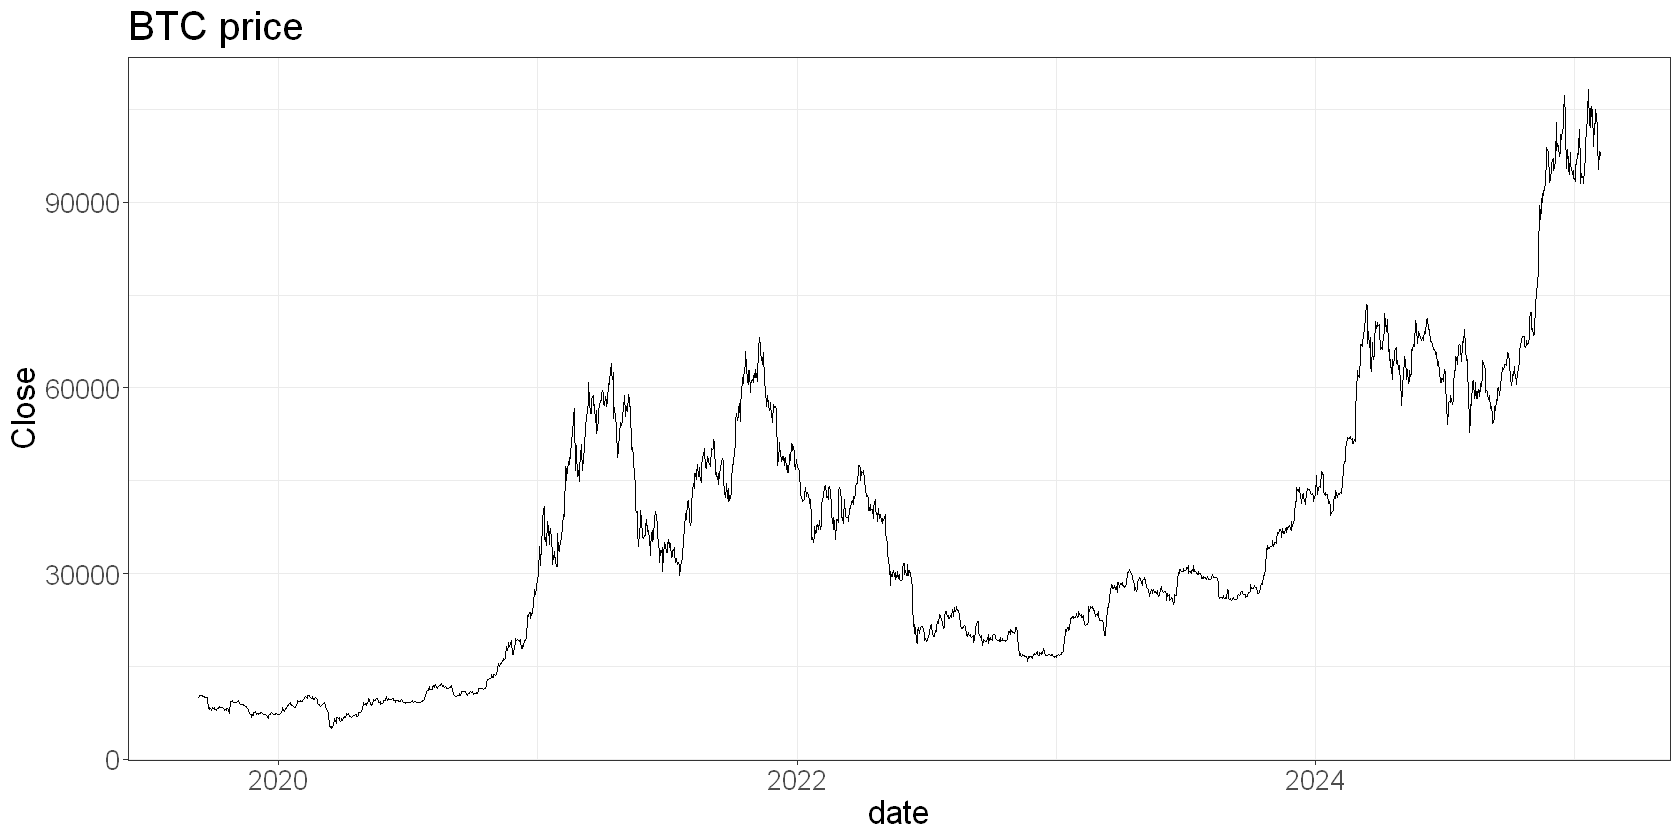

In [4]:
# plot prices
btc %>% 
  ggplot(aes(x = date, y = Close)) + geom_line() + ggtitle("BTC price")

Now we calculate the day-of-the-week seasonality in our data:

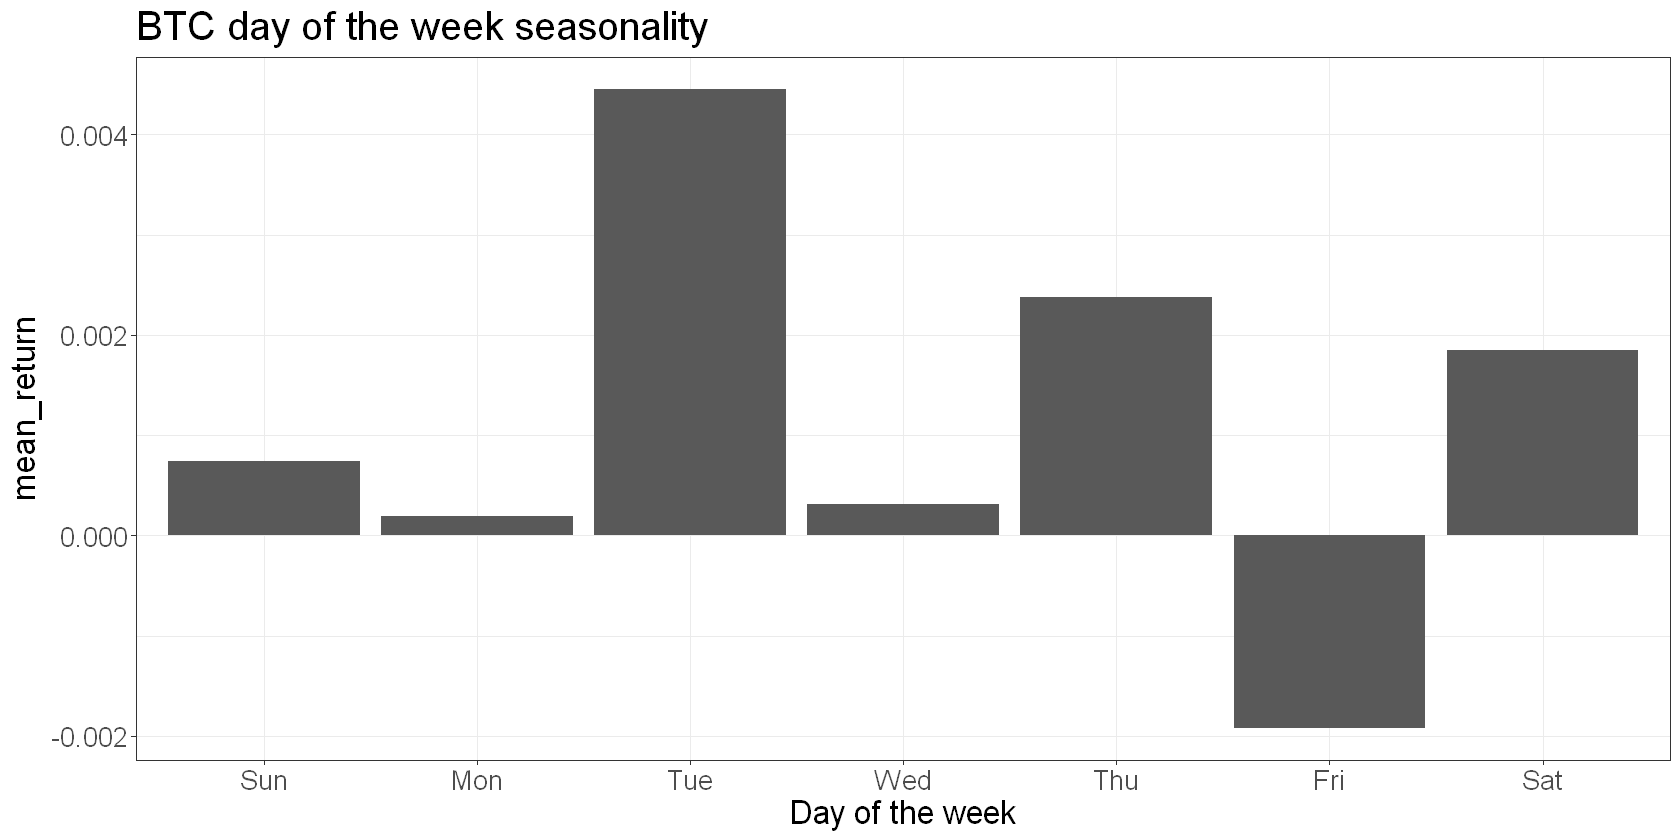

In [5]:
# seasonality within the actual data
actual <- btc %>% 
  group_by(dow) %>% 
  summarise(mean_return = mean(log_return))

actual %>% 
  ggplot(aes(x = dow, y = mean_return)) + 
  geom_bar(stat = "identity") +
  labs(
    title = "BTC day of the week seasonality",
    x = "Day of the week"
  )

We see that Tuesday's return is anomalously high. 

Could this be a real thing, or is it just a random artefact that is as likely to disappear as it is to continue?  

One thing that would *really* help answer that question is having a reason for the effect to exist. Is there anything special about Tuesday that would drive outsized BTC returns?

Maybe there is, but I can't think of anything. So I'm pretty skeptical from the outset. But I'm also open-minded and crypto is weird. 

Another thing we can do is to see how consistent the effect is over time. If it's relatively consistent, I'd have more confidence in it. 

`summarise()` has grouped output by 'year'. You can override using the
`.groups` argument.


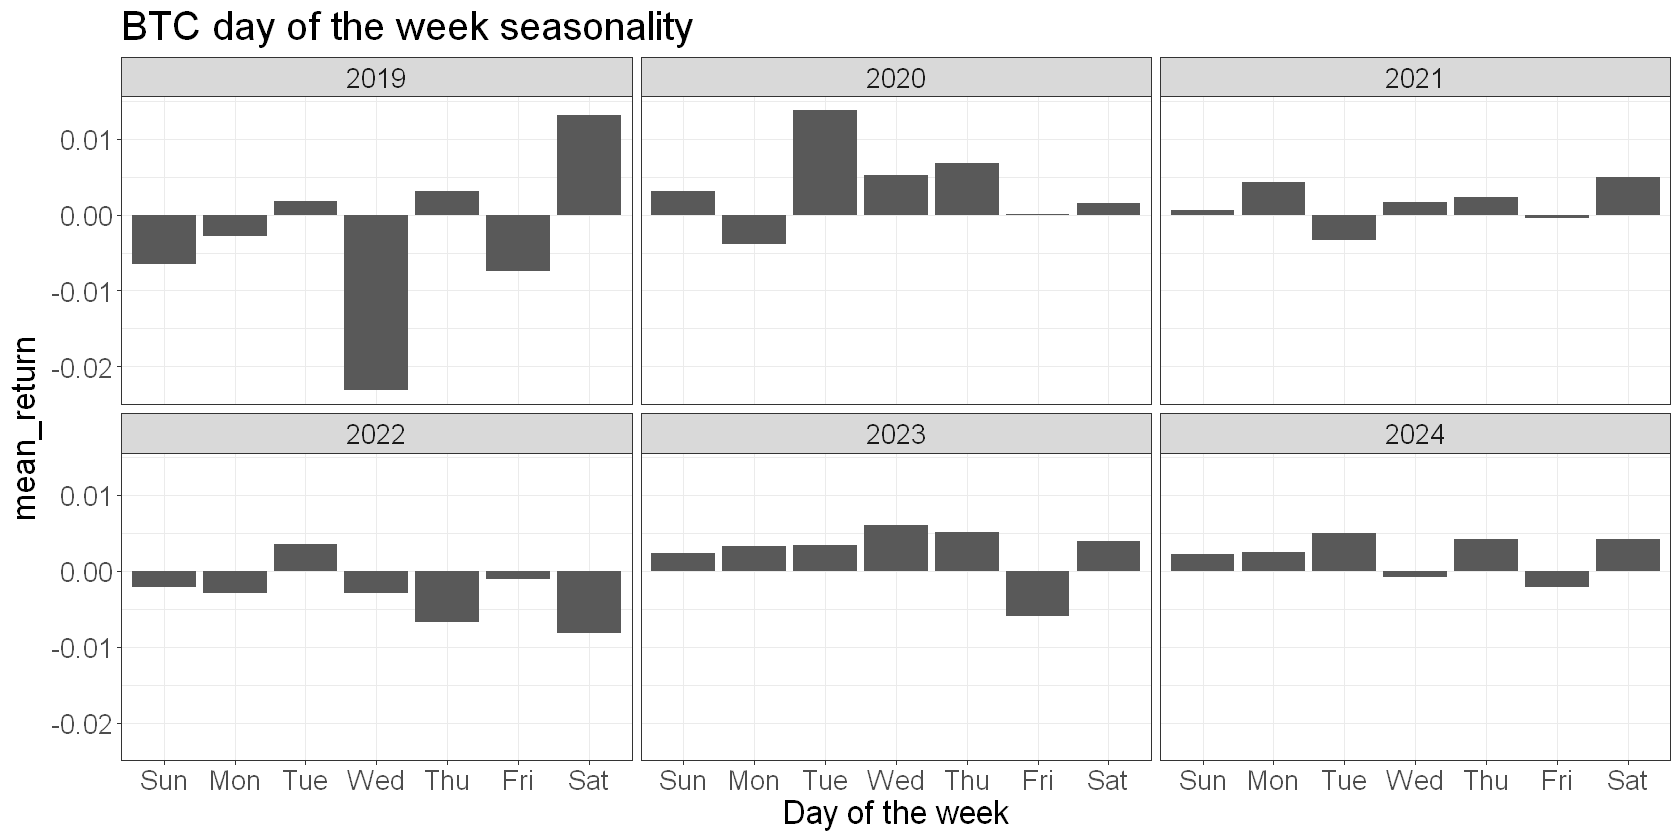

In [6]:
# consistency over time
btc %>% 
  dplyr::filter(date < "2025-01-01")  %>% # ditch 2025 due to not much data
  mutate(year = year(date)) %>% 
  group_by(year, dow) %>% 
  summarise(mean_return = mean(log_return)) %>% 
  ggplot(aes(x = dow, y = mean_return)) + 
  geom_bar(stat = "identity") +
  facet_wrap(~year) +
  labs(
    title = "BTC day of the week seasonality",
    x = "Day of the week"
  )

Interesting. The effet was concentrated in 2020 and 2022, although Tuesday's return was also positive in 2019, 2023 and 2024. It was negative in 2021 only.

This isn't exactly a slam dunk (nothing ever is). But at this point, I'm still interested enough to ask "What are the chances that we see is due to chance?"

We'll do that next. 

First, create randomised realisations of our actual returns data. This is called a Monte Carlo simulation or a permutation test. 

This preserves the aggregate statistical properties, but removes any time-series effects. 

Here's how to do it in R. We create 1000 randomised realisations and show a few rows of the first eight realisations:

In [26]:
# randomise data

# set a random seed so that we can replicate our results
set.seed(503)

# make a vector of log_returns for sampling from
log_returns <- btc %>% pull(log_return)

# shuffle returns n times

# replicate(n, expr, simplify = "array")
n <- 10000
shuffled_returns <- replicate(n, sample(log_returns, replace = FALSE))
colnames(shuffled_returns) <- as.character(1:n)

# print dimensions of our shuffled data - should have ~5000 rows and n columns
print(dim(shuffled_returns))

# show a few rows of the first few columns
shuffled_returns[1:5, 1:8]

[1]  1976 10000


1,2,3,4,5,6,7,8
-0.013188852,0.006773547,-0.001279188,0.012305932,0.104416248,-0.02452570,0.017921522,-0.0002473126
-0.035878538,-0.002501406,-0.085161578,-0.033513907,0.002073345,-0.00592268,-0.018492925,0.0157440030
-0.001647518,0.017940112,0.032785561,-0.036807225,0.002197926,0.02753803,-0.006317971,0.0020766585
0.023308866,-0.034073241,0.044463442,-0.002501406,-0.002309739,-0.02478223,-0.021543111,-0.0032618503
-0.020591047,-0.012364985,0.004061873,0.025448402,0.001785057,-0.01009072,0.001044578,0.0379236106


The final step in randomising our data is to label it with the data and day-of-week:

In [9]:
shuffled_returns <- as_tibble(shuffled_returns) %>%
  # bind date from actual data 
  bind_cols(btc %>% select(date)) %>% 
  # get dow column again - this completes our shuffling operation
  mutate(dow = wday(date, label = TRUE))


# look at the first few price series
shuffled_returns %>%
  select(date, dow, 1:10) %>%
  head()

date,dow,1,2,3,4,5,6,7,8,9,10
<date>,<ord>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2019-09-11,Wed,-0.013188852,0.006773547,-0.001279188,0.012305932,0.104416248,-0.02452570,0.017921522,-0.0002473126,0.027514426,0.011997215
2019-09-12,Thu,-0.035878538,-0.002501406,-0.085161578,-0.033513907,0.002073345,-0.00592268,-0.018492925,0.0157440030,0.013408055,0.028417812
2019-09-13,Fri,-0.001647518,0.017940112,0.032785561,-0.036807225,0.002197926,0.02753803,-0.006317971,0.0020766585,-0.002043919,-0.008948786
2019-09-14,Sat,0.023308866,-0.034073241,0.044463442,-0.002501406,-0.002309739,-0.02478223,-0.021543111,-0.0032618503,0.001044578,0.001325637
2019-09-15,Sun,-0.020591047,-0.012364985,0.004061873,0.025448402,0.001785057,-0.01009072,0.001044578,0.0379236106,-0.001143826,0.002183492
2019-09-16,Mon,-0.006850317,-0.017090585,-0.002702988,-0.003250093,0.014208444,0.01016963,-0.007822186,-0.0424397605,0.009484934,0.007220036


Let's plot a subset of these suffled series to get a sense of how they behave:

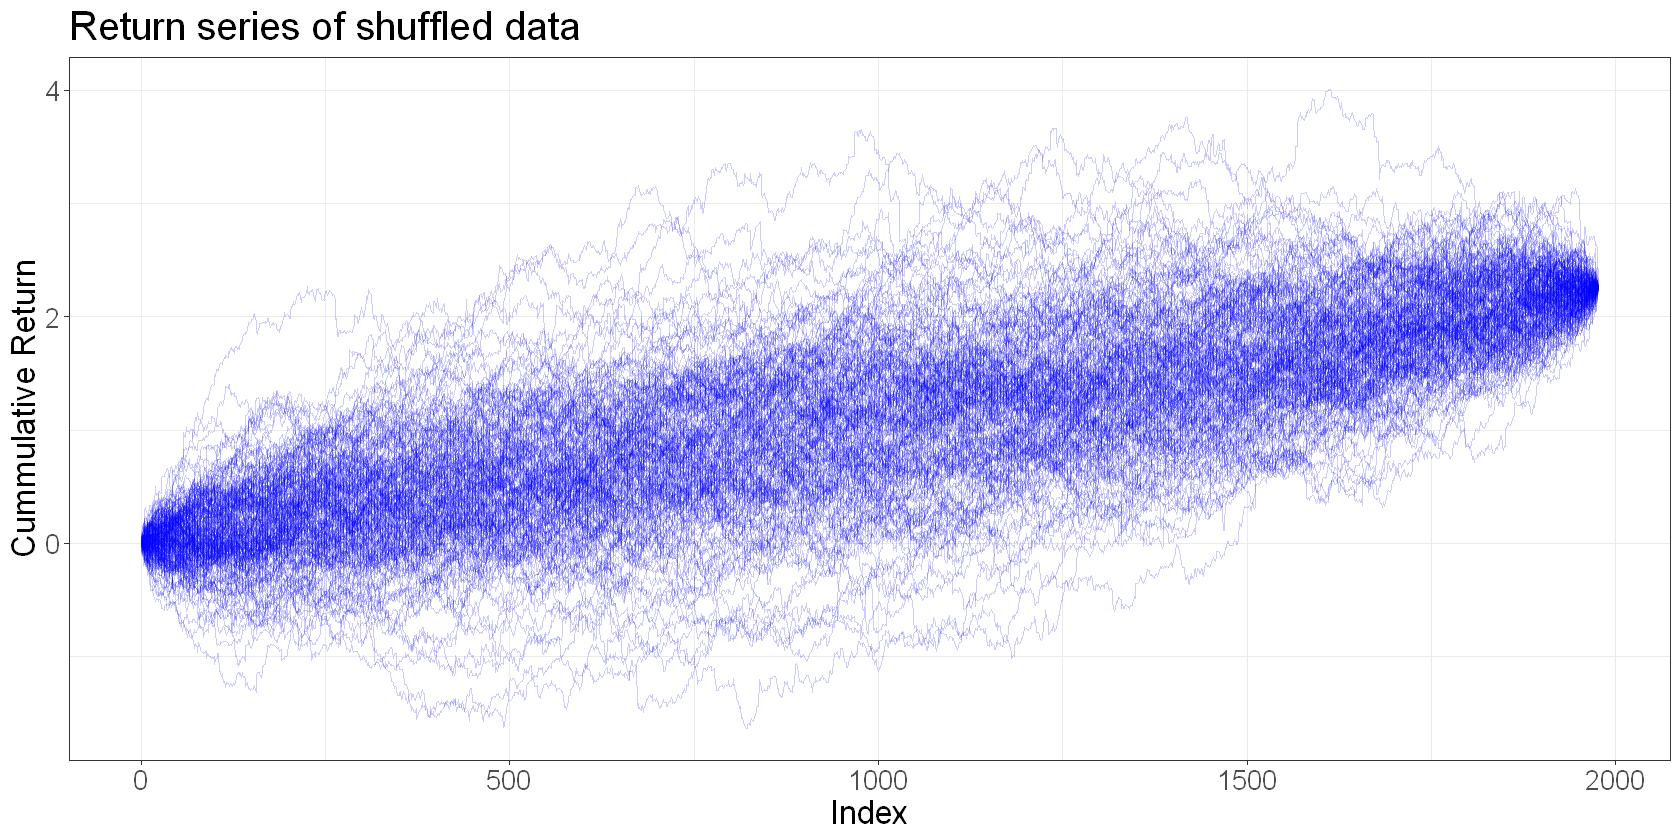

In [11]:
# plot shuffled series to get a sense of how they behave
shuffled_returns[, 1:200] %>%
  apply(2, FUN = cumsum) %>%
  as_tibble() %>%
  mutate(index = row_number()) %>%
  pivot_longer(cols = -index, names_to = "series", values_to = "price") %>%
  ggplot(aes(x = index, y = price)) +
    geom_line(aes(group = series), colour = "blue", alpha = 0.2) +
    labs(
      x = "Index",
      y = "Cummulative Return",
      title = "Return series of shuffled data"
    )

An interesting thing here is that, while the cumulative return plots are all up and to the right, you don't see much evidence of the trendiness that we observe in the actual BTC price series. The upmoves in the actual data tend to be clustered together, but in the randomised data, they don't. 

Without doing any actual analysis, that's suggestive that the trendiness we do observe is unlikely due to randomness. 

Now that we have 1000 realisation of randomised data, let's look at how our actual Tuesday return compares to the randomised returns. 

Let's consider the chances of *any* day of the week having a return as large as our Tuesday return. Since we have no good reason to think that Tuesday is special, this feels like a more relevant question.

To do this, we plot a histogram of the randomised day-of-week returns, and note where our actual Tuesday return lies on this distribution. 

This answers the question "what is the chance of the return we observed happening on any day due to chance?"

`summarise()` has grouped output by 'dow'. You can override using the `.groups`
argument.


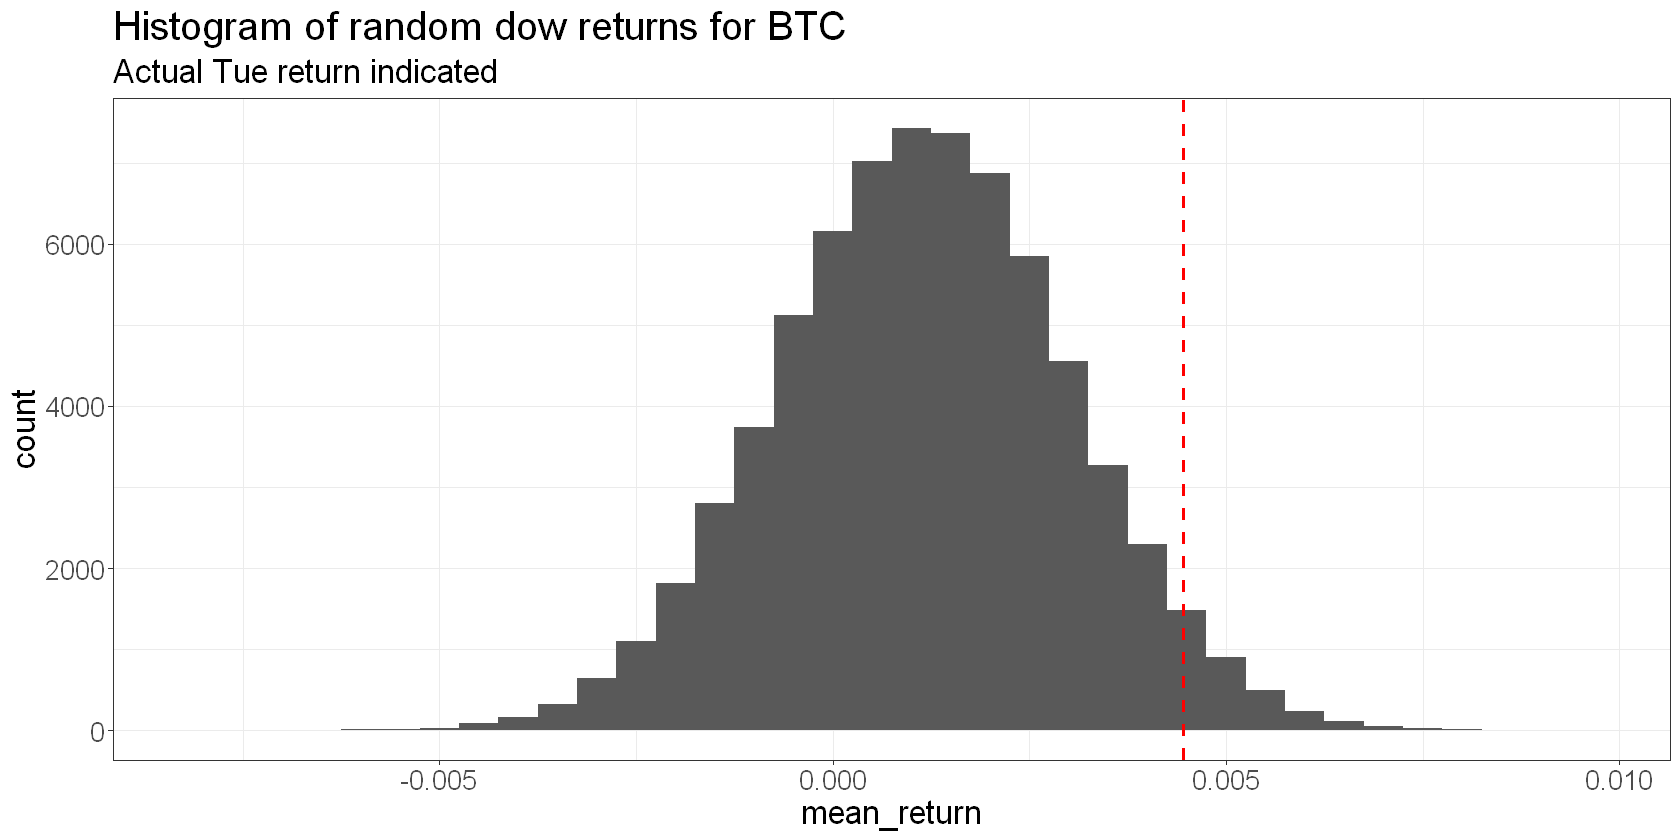

In [24]:
shuffled_mean_returns <- shuffled_returns %>% 
  pivot_longer(cols = c(-date, -dow), names_to = "series", values_to = "log_return") %>%  
  group_by(dow, series) %>% 
  # this gives us one row for each day and series
  summarise(mean_return = mean(log_return)) 

shuffled_mean_returns %>% 
  ggplot(aes(x = mean_return)) +
  geom_histogram(binwidth = 0.0005) +
  geom_vline(
    xintercept = actual_tue, 
    linetype = "dashed", 
    color = "red",
    size = 1
  ) +
  labs(
    title = "Histogram of random dow returns for BTC",
    subtitle = "Actual Tue return indicated"
  )  

The red dashed line shows where the actual Tuesday value lies. You can see that's larger than the vast majority of randomised day-of-week returns. 

If we calculate a p-value, we find that it's greater than about 96% of the randomly generated data points. Which most people would recognise as significant.

In [29]:
# ECDF
ecdf_function <- ecdf(shuffled_mean_returns$mean_return)

# p-value
p_value <- ecdf_function(actual_tue)

print(p_value)

[1] 0.9632286


Let's see how this result compares with a classic statistical test - the two sample t-test to assess whether the Tuesday returns are significantly different from the non-Tuesday returns. 

In [28]:
btc %>%
  mutate(season = if_else(wday(date, label = TRUE) == "Tue", "season_day", "non_season_day")) %>% 
  t.test(log_return ~ season, data = .)


	Welch Two Sample t-test

data:  log_return by season
t = -1.6573, df = 360.8, p-value = 0.09833
alternative hypothesis: true difference in means between group non_season_day and group season_day is not equal to 0
95 percent confidence interval:
 -0.0084516716  0.0007212696
sample estimates:
mean in group non_season_day     mean in group season_day 
                0.0005911068                 0.0044563078 


This results in a p-value of 0.1, indicating weak evidence against the null hypothesis (that the Tuesday and non-Tuesday returns come from the same distribution). It does not meet the conventional 5% significance threshold, but some might consider it suggestive.

I prefer the empirical approach over this statistical test because:
- The empirical test is intuitively much easier to understand than the parametric test. 
  - Without training in statistical methods, you don't really know what the t-test is doing. 
  - On the other hand, it's obvious what our empirical Monte Carlo approach is doing.
- The t-test is confusing (for example, what do we do with the degrees of freedom number (df=360.8))?
- The t-test has certain assumptions baked in, such as normality. It's not clear how much a violation of this assumption matters, but the empirical Monte Carlo approach has no assumptions about the distribution of the data. 
- That said, the Monte Carlo approach does assume that the data are independent and identically distributed (i.i.d.). Autocorrelation (aka trendiness, which I believe is present in BTC returns) would invalidate this assumption - but since it is likely mild, and we are exploring broad seasonal patterns, the test is likely reasonably robust. 

## Summary

Monte Carlo can help answer the question "What are the chances I'd see this effect by chance?"

Of course, it comes with the usual caveats around overfitting and cherry-picking results to fit your hypothesis. It's also worth thinking about the structure of your data - for instance, is autocorrelation present?

Remember that analysis of market effects requires gathering and weighing evidence from many different angles. Monte Carlo can be considered one of many such windows into a market effect, but remember that it doesn't guarantee success. Even if you find that an effect likely isn't due to chance, there's no guarantee that you'll make money trading it:
- Maybe it's real but too small to overcome trading costs.
- Maybe it's a real effect, but has decayed because it's well-known.

Often, the art in applying this technique is in thinking about the question that you want answered or framing the problem sensibly. Sometimes it will be obvious, as in our example here, and other times less so.

But Monte Carlo is a useful tool to add to your data analysis toolkit, allowing you to make meaningful statistical comparisons without resorting to classical statistics. 